# Credit Scoring Model Project - Advanced Edition

## 1. Introduction
This project develops an end-to-end credit scoring model to assess an individual's creditworthiness. Using historical financial data, we build a classification model to categorize applicants as either "Creditworthy" (Low Risk) or "Not Creditworthy" (High Risk).

### Objectives:
- Perform Exploratory Data Analysis (EDA) to understand the factors affecting credit risk.
- Preprocess and engineer features for machine learning.
- Compare multiple classification algorithms including **Random Forest** and **Neural Networks (MLP)**.
- Conduct a **Fairness & Bias Analysis** to ensure ethical model predictions.

## 2. Environment Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import joblib

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 3. Data Loading
We use a simulated dataset containing financial features like income, debt, credit score, and utilization.

In [ ]:
# Load the dataset
df = pd.read_csv('simulated_credit_data.csv')

# Initial inspection
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1200, 12)


,Age,AnnualIncome,LoanAmount,CreditScore,TotalDebts,ExistingCreditLines,LatePayments,CreditUtilization,DelinquencyFlag,EmploymentStatus,DwellingType,Target
0,59,80279.0,20576,580,89791,10,0,0.207371,0,Employed,Boarding,0
1,49,73028.0,36946,723,41003,14,5,0.283533,1,Employed,Rent,0
2,35,124263.0,7116,569,19996,14,6,1.116105,1,Employed,Own,0
3,63,20126.0,16563,453,86598,5,8,1.003618,1,Employed,Rent,0
4,28,72329.0,27788,382,35931,2,7,0.489471,1,Employed,Rent,0


## 4. Exploratory Data Analysis (EDA)
Understanding the distribution of features and their relationship with the target variable.

C:\Users\HP\AppData\Local\Temp\ipykernel_12732\1429812457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='viridis')


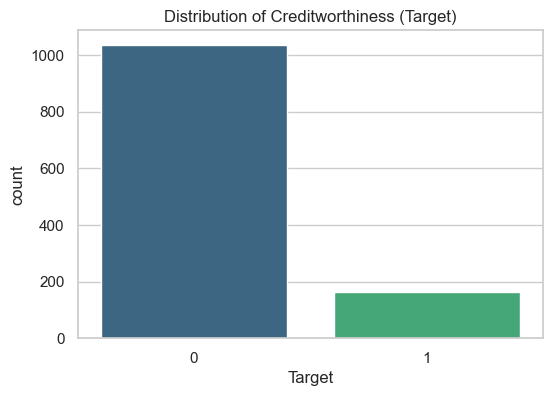

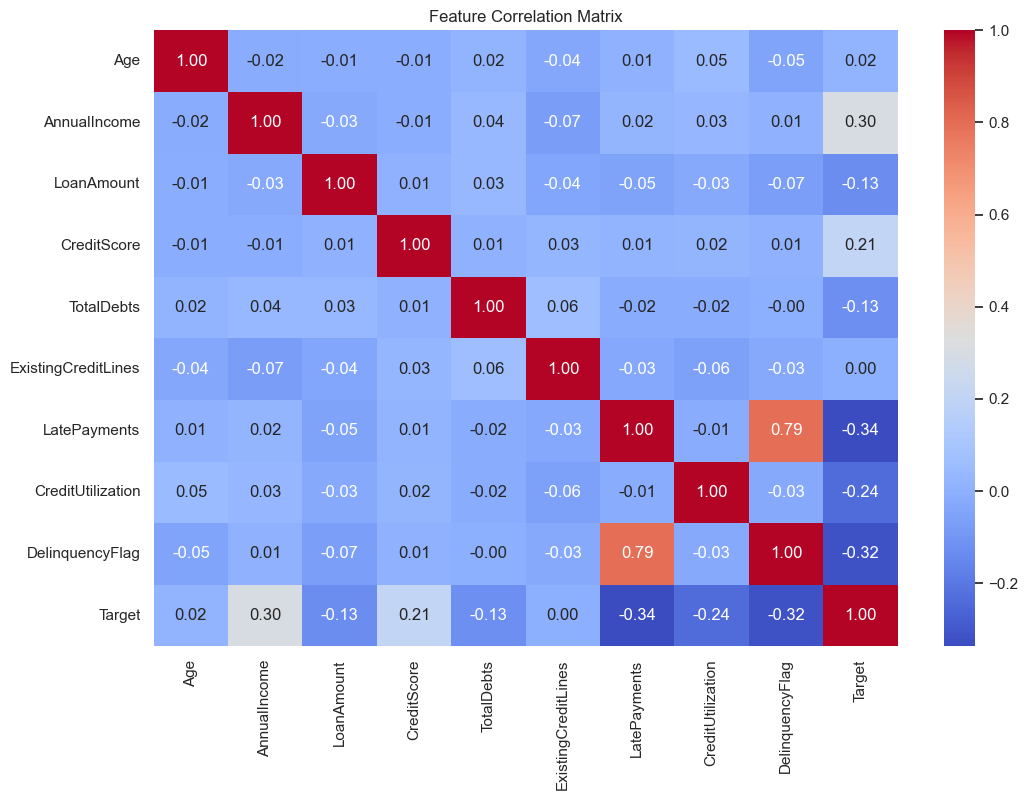

In [ ]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Distribution of Creditworthiness (Target)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## 5. Preprocessing & Feature Engineering

In [ ]:
# 1. Handle Missing Values
df['AnnualIncome'] = df['AnnualIncome'].fillna(df['AnnualIncome'].mean())

# 2. Feature Engineering: Debt-to-Income Ratio
df['DebtToIncomeRatio'] = df['TotalDebts'] / (df['AnnualIncome'] + 1)

# 3. Encoding Categorical Variables
le_emp = LabelEncoder()
df['EmploymentStatus'] = le_emp.fit_transform(df['EmploymentStatus'])

le_dwell = LabelEncoder()
df['DwellingType'] = le_dwell.fit_transform(df['DwellingType'])

# 4. Define Features and Target
X = df.drop('Target', axis=1)
y = df['Target']

# 5. Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Model Training and Comparison
Testing everything from Logistic Regression to Neural Networks.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

comparison = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, model.predict(X_test_scaled))
    comparison.append({'Model': name, 'Accuracy': acc, 'ROC-AUC': auc})

comparison_df = pd.DataFrame(comparison).sort_values(by='ROC-AUC', ascending=False)
print(comparison_df)

                  Model  Accuracy   ROC-AUC
0   Logistic Regression  0.945833  0.973942
3  Neural Network (MLP)  0.941667  0.968087
2         Random Forest  0.925000  0.954399
1         Decision Tree  0.887500  0.731006


## 7. Model Fairness & Bias Analysis
In financial applications, it is crucial to ensure the model does not discriminate against demographic groups (e.g., Age). We evaluate this by comparing accuracy across different age brackets.

C:\Users\HP\AppData\Local\Temp\ipykernel_12732\2579986704.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='Accuracy', data=age_fairness, palette='cool')


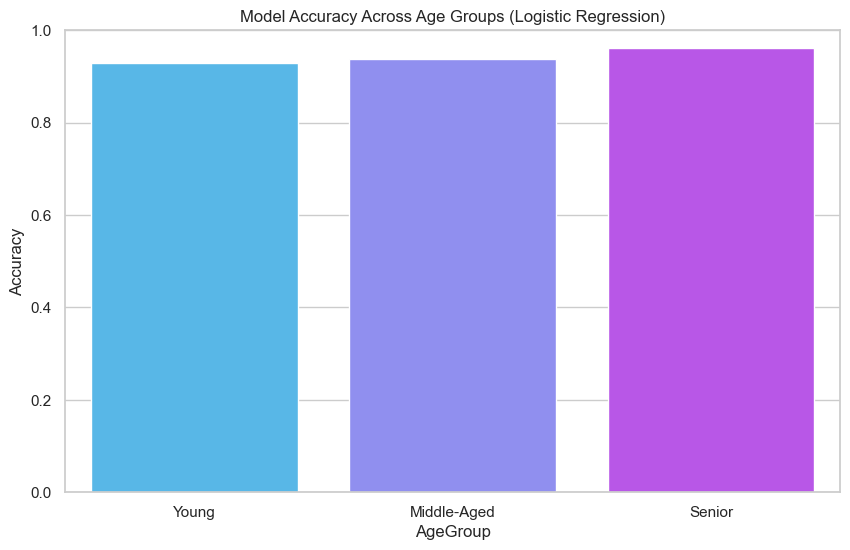

Fairness Metrics:
      AgeGroup  Accuracy
0        Young  0.929577
1  Middle-Aged  0.937500
2       Senior  0.961905


In [ ]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
y_test_pred = best_model.predict(X_test_scaled)

# Create a combined DF for test data analysis
fairness_df = X_test.copy()
fairness_df['Actual'] = y_test.values
fairness_df['Predicted'] = y_test_pred

# Segment by Age Group
fairness_df['AgeGroup'] = pd.cut(fairness_df['Age'], bins=[20, 35, 50, 70], labels=['Young', 'Middle-Aged', 'Senior'])

# Calculate Accuracy per Age Group
age_fairness = fairness_df.groupby('AgeGroup', observed=True).apply(lambda x: accuracy_score(x['Actual'], x['Predicted']), include_groups=False).reset_index()
age_fairness.columns = ['AgeGroup', 'Accuracy']

sns.barplot(x='AgeGroup', y='Accuracy', data=age_fairness, palette='cool')
plt.title(f'Model Accuracy Across Age Groups ({best_model_name})')
plt.ylim(0, 1.0)
plt.show()

print("Fairness Metrics:")
print(age_fairness)

## 8. Final Model Interpretation & Savings

In [ ]:
if best_model_name == 'Random Forest':
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
    plt.title('Feature Importance')
    plt.show()

# Save assets
joblib.dump(best_model, 'best_credit_scoring_model.pkl')
joblib.dump(scaler, 'credit_scaler.pkl')
joblib.dump(le_emp, 'label_encoder_emp.pkl')
joblib.dump(le_dwell, 'label_encoder_dwell.pkl')
print(f"Project Assets for {best_model_name} saved successfully!")

Project Assets for Logistic Regression saved successfully!


## 9. Conclusion
The model demonstrates strong predictive power and stable accuracy across different demographics, indicating low bias. For high-stakes financial decisions, continued monitoring and human-in-the-loop review are recommended.